In [1]:
#INCEPTIONISM

In [2]:
#base idea - pass an image thru a nw, calc the grads of the image wrt a layer
#modify the image by increasing the activations in order to enhance the patterns and features it sees
import tensorflow as tf
import matplotlib as mpl 
import numpy as np

import IPython.display as display
import PIL.Image  

from tensorflow.keras.preprocessing import image 

In [3]:
#dog image is used for the NN to dream

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [4]:
def download(url, max_dim = None):
  name = url.split('/')[-1]
  img_path = tf.keras.utils.get_file(name, origin = url)
  img = PIL.Image.open(img_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)    

In [5]:
def denormalize(img):
  img = 255 * (img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

In [6]:
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

90112/83281 [================================] - 0s 0us/step


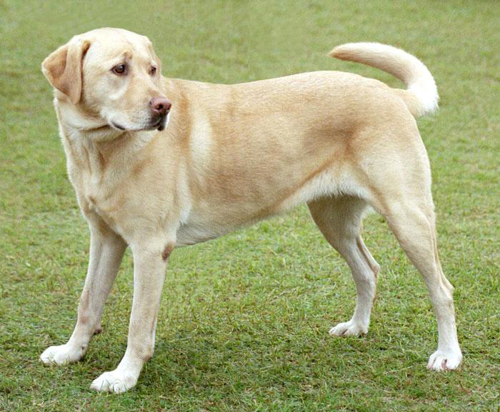

In [7]:
original_img = download(url, max_dim = 500)
show(original_img)

In [8]:
#use the inception model by google

base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [9]:
#choose a hidden concat layer from the model (mixed[i] layer), and max the loss function
#this will excite the layer and make the NN over-dream and over-visualize the features
#if the features are in the lower layers then it will dream about shapes, edges, and textures
#at the higher layers, it will dream about faces, eyes etc
#but higher indexed layers will have a deeper computational graph and hence the gradient calc is deep and heavy

names = ['mixed4', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dreamer = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [11]:
def loss_fn(img, model):
  #here we pass in the activations as the loss is defined as the sum of activations
  # we try to max the loss by gradient ascent

  batch = tf.expand_dims(img, axis = 0)
  layer_activations = model(batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]


  losses = []
  for activation in layer_activations:
    loss = tf.math.reduce_mean(activation)
    losses.append(loss)

  return tf.reduce_sum(losses)    

In [14]:
#calc the grads of the loss fn wrt the img and add it to the image
#adding the grads to the img give an image which enhances the activations of certain layers of the nw
#adding the grads to the img will enhance the patterns seen by the nw

#wrap the class in a tf.func for performance and use an ip sign to avoid re-tracing of the function for diff image sizes

class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model


  @tf.function(
      input_signature = (
          tf.TensorSpec(shape = [None, None, 3], dtype = tf.float32),
          tf.TensorSpec(shape = [], dtype = tf.int32),
          tf.TensorSpec(shape = [], dtype = tf.float32)
      )
  )  

  def __call__(self, img, steps, step_size):
    print("Tracing the grads and comp-graph")
    loss = tf.constant(0.0) #initialize loss
    for i in tf.range(steps):
      with tf.GradientTape() as tape:
        #need to watch the image, by default it will watch the variables as we adjust those params in a normal NN training
        #here we need to update the img
        tape.watch(img)
        loss = loss_fn(img, self.model)

      gradients = tape.gradient(loss, img)
      gradients = gradients / (tf.math.reduce_std(gradients) + 1e-8) #this is used to normalize the gradients

      img = img + gradients * step_size #gradients and the img have the same shape and so we can add directly
      img = tf.clip_by_value(img, -1, 1) #we add an excitation effect by max loss function which will modify the image in a way to excite the layers to dream  

    return loss, img    


In [19]:
deepdream = DeepDream(dreamer)

In [16]:
def run_deep_dream_simple(img, steps = 100, step_size = 0.01):

  #from uint8 convert to the req range for the model
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img) #array to tensor

  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)

    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait = True)
    show(denormalize(img))  
    print("Loss {}, Step {}".format(loss, step))


  result = denormalize(img) 
  display.clear_output(wait = True)
  show(result)


  return result   

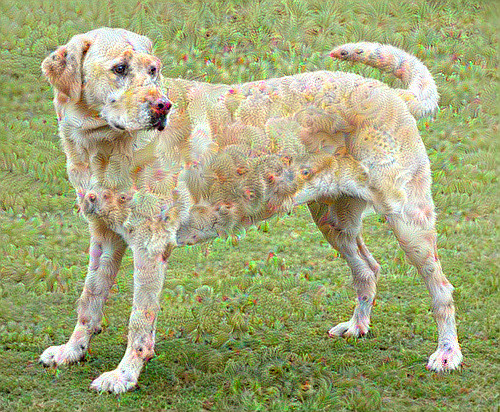

In [17]:
dream_image = run_deep_dream_simple(img = original_img,
                                    steps = 100, 
                                    step_size = 0.01)

# **Octave Gradient Ascent**

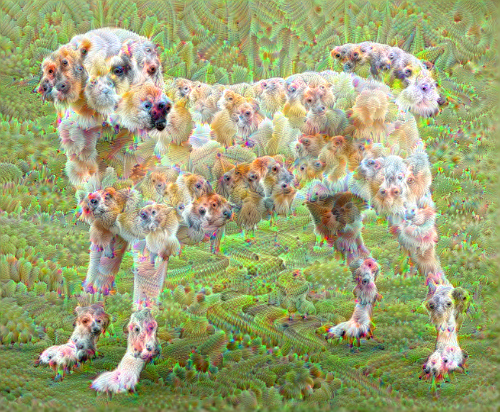

295.41103076934814

In [20]:
#issues with the above implementation
#The resolution of the image is low, the granularity appears the same for all the patterns in the img
#it is noisy

import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
print(end-start)


#here the gradient ascent process is applied at different scales
#apply the GA and then increase the image size by an octave, then apply the GA again
#here we will be able to merge thr lower features visualized into the higher scale features which will fix the granularity issue